In [18]:
import pandas as pd
import numpy as np
import requests
import json
import astropy.io.ascii as ascii
import os
import copy
import time

# Time Counter function
def tic():
    tic.start = time.perf_counter()
def toc():
    elapsed_seconds = time.perf_counter() - tic.start
    return elapsed_seconds # fractional

# NOAO server Settings
natroot = 'https://astroarchive.noirlab.edu'
assert natroot == 'https://astroarchive.noirlab.edu', 'Notebook does NOT point to PRODUCTION'
adsurl = f'{natroot}/api/adv_search'
apiurl = f'{adsurl}/fasearch/?limit=200000'

print(f"Using server on {natroot}")
print(f"adsurl = {adsurl}")
print(f'Using API url: {apiurl}')

# Start the timer
print(f'Started on: {str(datetime.datetime.now())}')
tic() # Start timing the run of this notebook

Using server on https://astroarchive.noirlab.edu
adsurl = https://astroarchive.noirlab.edu/api/adv_search
Using API url: https://astroarchive.noirlab.edu/api/adv_search/fasearch/?limit=200000
Started on: 2022-02-04 23:58:23.331748


In [2]:
pw                = 'DWFL2016a'
usrname           = 'jcooke@astro.swin.edu.au'
fieldname         = 'S82sub8'
search_radius_deg = 40./60./60.
caldat1           = "2021-06-05"
file_string       = 'kfttest'
prod_types_to_get = ['image1','wtmap','dqmask'] # photpipe no need "expmap" I think
raw_dir           = '/Users/jielaizhang/Desktop'
f_field_centres   = '/Users/jielaizhang/src/KNTraP/notes/DWF.fieldcenters'

In [19]:


ccd_code_dic = {
1:'S29', '1':'S29',
2:'S30', '2':'S30',
3:'S31', '3':'S31',
4:'S25', '4':'S25',
5:'S26', '5':'S26',
6:'S27', '6':'S27',
7:'S28', '7':'S28',
8:'S20', '8':'S20',
9:'S21', '9':'S21',
10:'S22', '10':'S22',
11:'S23', '11':'S23',
12:'S24', '12':'S24',
13:'S14', '13':'S14',
14:'S15', '14':'S15',
15:'S16', '15':'S16',
16:'S17', '16':'S17',
17:'S18', '17':'S18',
18:'S19', '18':'S19',
19:'S8', '19':'S8',
20:'S9', '20':'S9',
21:'S10', '21':'S10',
22:'S11', '22':'S11',
23:'S12', '23':'S12',
24:'S13', '24':'S13',
25:'S1', '25':'S1',
26:'S2', '26':'S2',
27:'S3', '27':'S3',
28:'S4', '28':'S4',
29:'S5', '29':'S5',
30:'S6', '30':'S6',
31:'S7', '31':'S7',
32:'N1', '32':'N1',
33:'N2', '33':'N2',
34:'N3', '34':'N3',
35:'N4', '35':'N4',
36:'N5', '36':'N5',
37:'N6', '37':'N6',
38:'N7', '38':'N7',
39:'N8', '39':'N8',
40:'N9', '40':'N9',
41:'N10', '41':'N10',
42:'N11', '42':'N11',
43:'N12', '43':'N12',
44:'N13', '44':'N13',
45:'N14', '45':'N14',
46:'N15', '46':'N15',
47:'N16', '47':'N16',
48:'N17', '48':'N17',
49:'N18', '49':'N18',
50:'N19', '50':'N19',
51:'N20', '51':'N20',
52:'N21', '52':'N21',
53:'N22', '53':'N22',
54:'N23', '54':'N23',
55:'N24', '55':'N24',
56:'N25', '56':'N25',
57:'N26', '57':'N26',
58:'N27', '58':'N27',
59:'N28', '59':'N28',
60:'N29', '60':'N29',
61:'N30', '61':'N30',
62:'N31', '62':'N31'
}

def makedirs_(out_path):
    out_dir = '/'.join(out_path.split('/')[0:-1])
    os.makedirs(out_dir, exist_ok=True)
    return None

jj_base = {    
        "outfields" : [
            "md5sum",
            "archive_filename",
            "original_filename",
            "proc_type",
            "prod_type",
            "proposal",
            "ra_center",
            "dec_center",
            "caldat",
            "url",
            "filesize",
            "ifilter",
            "exposure",
            "dateobs_min",
            "dateobs_max" 
            ],
        "search" : [ ["instrument", 'decam'],
                     ["telescope", 'ct4m'],
                     ["obs_type", 'object'],
                     ["proc_type","stacked"],
                     ["caldat",caldat1,caldat1],
                     ["ifilter","g DECam SDSS c0001 4720.0 1520.0"]
                   ]
    }
# Note: 'The local calendar date of the telescope, at the start of PM observing.' = caldat

In [ ]:
                     ["caldat",caldat1,caldat1],
                     ["ifilter","g DECam SDSS c0001 4720.0 1520.0"]


In [20]:
d_field_centres                = ascii.read(f_field_centres)
df_field_centres               = pd.DataFrame(d_field_centres.as_array())
df_field_centres_selectedfield = df_field_centres[df_field_centres['field']==fieldname]

for ii in [0,1]: # np.arange(len(df_field_centres_selectedfield))
    ccd               = df_field_centres_selectedfield.iloc[ii]['ampl']
    print(f'\n############### Working on CCD {ccd} ###############\n')
    RAcentre          = df_field_centres_selectedfield.iloc[ii]['RAdeg'] #226.54167   
    DECcentre         = df_field_centres_selectedfield.iloc[ii]['DECdeg'] #9.54861


    dec_min = DECcentre - search_radius_deg
    dec_max = DECcentre + search_radius_deg
    if dec_min<-90.0: dec_min=-90.0
    if dec_max>90.0: dec_max=90.0
    if dec_min==-90.0 or dec_max==90.0:
        ra_min = 0
        ra_max = 360.0
    else:
        costerm = min(np.cos(dec_min*np.pi/180.0),np.cos(dec_max*np.pi/180.0))
        ra_min = RAcentre-search_radius_deg*1./costerm
        ra_max = RAcentre+search_radius_deg*1./costerm
        if ra_min<0: ra_min+=360.0
        if ra_max>360.0: ra_max-=360.0
    print(dec_min, dec_max)
    print(ra_min, ra_max)

    # Figure out the RA and DEC centre search criteria and then perform search
    if ra_min>ra_max:
        raise RuntimeError('This needs to be fixed!!')
        # Need to perform two searches to account for overlap
        
    else:
        jj=copy.deepcopy(jj_base)
        print(jj['search'])
        jj['search'].append(['ra_center',ra_min,ra_max])
        jj['search'].append(['dec_center',dec_min,dec_max])
        print(jj['search'])

        ads_df = pd.DataFrame(requests.post(apiurl,json=jj).json()[1:])

    print('Retrieved: ',len(ads_df))
    ads_df_with_string = ads_df[ [file_string_in_x(x,file_string) for x in ads_df['archive_filename']] ]
    print(f'Retrieved and Pruned with {file_string}: ',len(ads_df_with_string))
    print('')

    for index, row in ads_df_with_string.iterrows():
        if row['prod_type'] in prod_types_to_get:
            print('\n======================')
            print('WORKING ON A NEW FILE:',row['archive_filename'].split('/')[-1])
            print('======================')
            for k in row.keys():
                print(f'{k:18s}: {row[k]}')
            dlink  = row['url']
            caldat = row['caldat'].replace('-','')
            band   = row['ifilter'].split(' ')[0]
            ccd_code = ccd_code_dic[ccd]
            prod_type_code = row['archive_filename'].split('/')[-1].split('_')[3]
            out_file_name = f'{fieldname}.{caldat}_{prod_type_code}_{band}_{file_string}_{ccd_code}.fits.fz'
            out_path      = f'{raw_dir}/{fieldname}/{ccd}/{out_file_name}'
            makedirs_(out_path)

            fileID = row['md5sum']
            print(' ')
            print('Save as: ',out_path)

            headers = dict()
            fileurl = f'{natroot}/api/retrieve/{fileID}'
            tokurl = f'{natroot}/api/get_token/'
            auth = dict(email=usrname, password=pw)

            print('... Downloading...:')
            r = requests.post(tokurl, json=auth)
            if r.status_code == 200:
                token = r.json()
                headers = dict(Authorization=token)
                #print(f'headers={headers}\n')
                r2 = requests.get(fileurl,headers=headers)
                if r2.status_code == 200:
                    print(f'Read file with size={len(r2.content):,} bytes')
                    open(out_path, 'wb').write(r2.content) # write temp file
                    print(f'Saved: {out_path}')
                else:
                    msg = f'Error getting file ({requests.status_codes._codes[r2.status_code][0]}). {r2.json()["message"]}'
                    raise Exception(msg)
            else:
                raise Exception(f"Could got get authorization: {token['detail']}")


############### Working on CCD 1 ###############

10.43749388888889 10.459716111111112
226.2194161332687 226.2420138667313
[['instrument', 'decam'], ['telescope', 'ct4m'], ['obs_type', 'object'], ['proc_type', 'stacked'], ['caldat', '2021-06-05', '2021-06-05'], ['ifilter', 'g DECam SDSS c0001 4720.0 1520.0']]
[['instrument', 'decam'], ['telescope', 'ct4m'], ['obs_type', 'object'], ['proc_type', 'stacked'], ['caldat', '2021-06-05', '2021-06-05'], ['ifilter', 'g DECam SDSS c0001 4720.0 1520.0'], ['ra_center', 226.2194161332687, 226.2420138667313], ['dec_center', 10.43749388888889, 10.459716111111112]]
Retrieved:  4
Retrieved and Pruned with kfttest:  4


WORKING ON A NEW FILE: c4d_210606_050730_osw_g_kfttest_01.fits.fz
md5sum            : a2caa3076f6fae00dbb77948e5ea92bb
archive_filename  : /net/archive/pipe/20210605/ct4m/2020B-0253/c4d_210606_050730_osw_g_kfttest_01.fits.fz
original_filename : /data_local/images/DTS/2020B-0253/DECam_01006851.fits.fz
proc_type         : stacked
prod_typ

Text(0.5, 1.0, 'all fields observed during DWF run 2021 June')

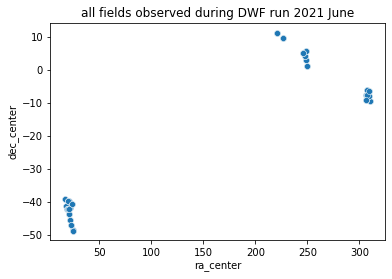

In [4]:
sns.scatterplot(data=ads_df, x="ra_center", y="dec_center")
plt.title("all fields observed during DWF run 2021 June")

# Wrap up

In [19]:
elapsed = toc()
print(f'Elapsed seconds={elapsed} on {natroot}')
print(f'Completed on: {str(datetime.datetime.now())}')

Elapsed seconds=39.04439736800123 on https://astroarchive.noirlab.edu
Completed on: 2022-01-08 13:10:09.048005
